In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
sns.set()
%matplotlib inline

In [44]:
from scipy.stats import norm

In [59]:
sigma = 1.
mu = 0.0
N = 1000

(array([110.,  94., 102., 105.,  92., 104.,  94.,  91., 108., 100.]),
 array([4.44235671e-04, 1.00311153e-01, 2.00178071e-01, 3.00044989e-01,
        3.99911906e-01, 4.99778824e-01, 5.99645742e-01, 6.99512660e-01,
        7.99379577e-01, 8.99246495e-01, 9.99113413e-01]),
 <a list of 10 Patch objects>)

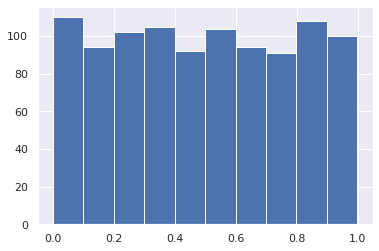

In [60]:
plt.hist([1 - norm(loc=0., scale=sigma / np.sqrt(N)).cdf(mu + np.random.randn(N).mean()) for _ in range(1000)])

$\newcommand{L}[1]{\| #1 \|}\newcommand{VL}[1]{\L{ \vec{#1} }}\newcommand{R}[1]{\operatorname{Re}\,(#1)}\newcommand{I}[1]{\operatorname{Im}\, (#1)}$

# 1. Коррекция Бонферрони
(Адаптировано из https://matthew-brett.github.io/teaching/bonferroni_correction.html)


Коррекция Бонферрони задаёт такую коррекция уровня отсечения по некой статистики, которая регулирует вероятность *хотя бы раз* совершить ошибку I рода. 

### Family-wise error

Мы пытаемся найти $\theta$ -- threshold(уровень отсечения), что $p(\mathrm{p-value}_i < \theta) = \alpha, \forall \mathrm{p-value_i} \in \{ \mathrm{p-value_i} \}_{i=1}^{n}$

### Коррекция Сидака

Начнём с более простой коррекции для объяснения -- коррекция Сидака.

Вероятность что для всех $n$ тестов p-value *больше* уровня отсечения $\theta$, *в предположении независимости тестов*:

$$
(1 - \theta)^n
$$

Тогда шанс, что хотя бы для одного p-value верно $\mathrm{p-value} \le \theta$:

$$
1 - (1 - \theta)^n
$$

Зададим групповую вероятность ошибки I первого рода(FWER):

$$
\alpha_{fwe} = 1 - (1 - \theta)^n
$$

И найдём $\theta$:

$$
\theta = 1 - (1 - \alpha_{fwe})^{1 / n}
$$

Например, для $\alpha_{fwe} = 0.05$:

In [2]:
def sidak_thresh(alpha_fwe, n):
    return 1 - (1 - alpha_fwe)**(1./n)

print(sidak_thresh(0.05, 10))

0.005116196891823743


# Коррекция Бонферрони

Коррекция Бонферрони использует неравенство Буля, которое утверждает, что вероятность хотя бы одного события не больше чем сумма вероятностей всех индивидуальных событий:

$$
\P\biggl(\bigcup_{i} A_i\biggr) \le \sum_i {\mathbb P}(A_i).
$$

Что очевидно следует из диаграмм Виета.

Тогда мы очевидно следует, что требуется следующая коррекция:

$$
\frac{\alpha_{fwe}}{n} \le \theta
$$

Например, для $\alpha_{fwe} = 0.05$ и $n=10$:

In [3]:
def bonferroni_thresh(alpha_fwe, n):
    return alpha_fwe / n

print(bonferroni_thresh(0.05, 10))

0.005


*Коррекция Бонферрони не использует предположения о независимости тестов*

Ёто означает, что коррекция Бонферрони более консервативная(строгая), когда предположение о независимости не выполняется.

Коррекция Бонферрони
$\theta_{Bonferroni} = \alpha_{fwe} \space / \space n$ всегда строже Спивака $\theta_{Šidák}$ для $n \ge 1$, но всё же близка:

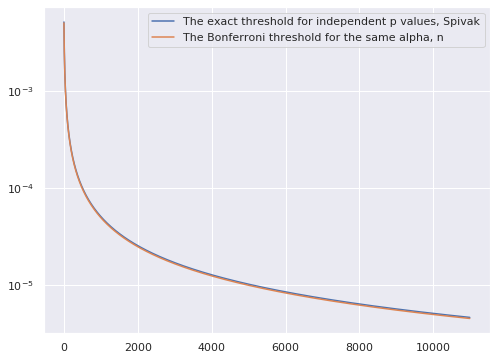

In [4]:
n_tests = np.arange(10, 11000)  # n = 1 through 10

plt.figure(figsize=(8, 6))
plt.plot(sidak_thresh(0.05, n_tests), label="The exact threshold for independent p values, Spivak")
plt.plot(bonferroni_thresh(0.05, n_tests), label="The Bonferroni threshold for the same alpha, n")
plt.yscale('log')
plt.legend()
plt.show()

$\newcommand{L}[1]{\| #1 \|}\newcommand{VL}[1]{\L{ \vec{#1} }}\newcommand{R}[1]{\operatorname{Re}\,(#1)}\newcommand{I}[1]{\operatorname{Im}\, (#1)}$

# 2. FDR
(Адаптировано из https://matthew-brett.github.io/teaching/fdr.html)


FDR(Ожидаемая доля ложных отклонений) альтернативный вариант коррекции уровня отсечения.

В методе FDR мы фиксируем *матожидание числа ошибок первого рода*, т.е.:

$$
E(\mathrm{False Positive}) \leq N \alpha 
$$


Давайте посмотрим на пример с нормальным распределением:

In [5]:
N = 100
z_values = np.random.normal(size=N)

Переведём Z values в p-values:

In [6]:
import scipy.stats as stats
normal_distribution = stats.norm(loc=0, scale=1.)
# The normal CDF
p_values = normal_distribution.cdf(z_values)

И отсортируем их:

Text(0, 0.5, 'p value')

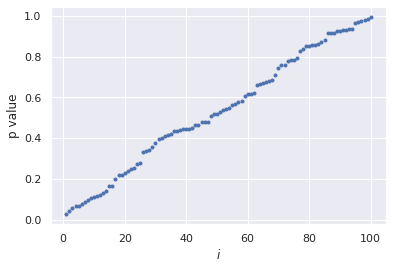

In [7]:
p_values = np.sort(p_values)
i = np.arange(1, N + 1) # the 1-based i index of the p values, as in p(i)
plt.plot(i, p_values, '.')
plt.xlabel('$i$')
plt.ylabel('p value')

Мы хотим найти такой трешхолд $\theta(i)$, что только небольшая часть принятных гипотез будет ошибочно принята.

То есть мы хотим подобрать такое $\theta(i)$, что:

$$E(\mathrm{FalsePositive}) / \mathrm{chosen} < \alpha$$


$$
N p(i) / i < \alpha \implies p(i) < \alpha i / N
$$

Давайте выберем $\alpha=0.05$. Нарисуем $q i / N$ (красная линия) вместе с $p(i)$ (синие точки):

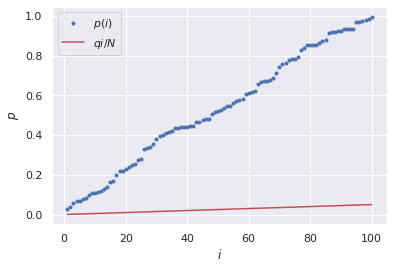

In [8]:
q = 0.05
plt.plot(i, p_values, 'b.', label='$p(i)$')
plt.plot(i, q * i / N, 'r', label='$q i / N$')
plt.xlabel('$i$')
plt.ylabel('$p$')
plt.legend()

Теперь добавим шум в наши измерения.

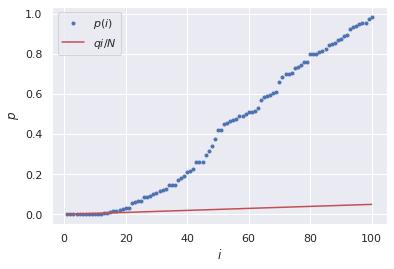

In [9]:
N_signal = 20
N_noise = N - N_signal
noise_z_values = np.random.normal(size=N_noise)
# Add some signal with very low z scores / p values
signal_z_values = np.random.normal(loc=-2.5, size=N_signal)
mixed_z_values = np.sort(np.concatenate((noise_z_values, signal_z_values)))
mixed_p_values = normal_distribution.cdf(mixed_z_values)
plt.plot(i, mixed_p_values, 'b.', label='$p(i)$')
plt.plot(i, q * i / N, 'r', label='$q i / N$')
plt.xlabel('$i$')
plt.ylabel('$p$')
plt.legend()

Посмотрим поближе на начало графика:

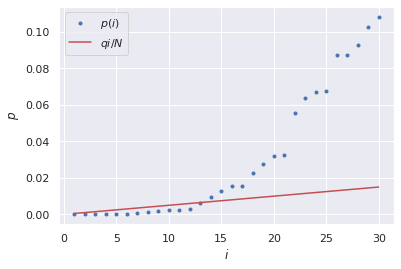

In [10]:
first_i = i[:30]
plt.plot(first_i, mixed_p_values[:30], 'b.', label='$p(i)$')
plt.plot(first_i, q * first_i / N, 'r', label='$q i / N$')
plt.xlabel('$i$')
plt.ylabel('$p$')
plt.legend()

In [11]:
below = mixed_p_values < (q * i / N) # True where p(i)<qi/N
max_below = np.max(np.where(below)[0]) # Max Python array index where p(i)<qi/N
print('p_i:', mixed_p_values[max_below])
print('i:', max_below + 1) # Python indices 0-based, we want 1-based

p_i: 0.006062846980295075
i: 13


# 3. Обучение модели машинного обучения и выбор лучшей

## Напишем свой собственный корректор с Бонферрони и FDR




In [12]:
from sklearn.datasets import make_classification
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold, cross_val_score, StratifiedKFold
from collections import defaultdict
from tqdm import tqdm
from sklearn.feature_selection import f_regression, chi2
from statsmodels.stats import multitest
import warnings
warnings.filterwarnings("ignore")

X, y = make_classification(n_samples=2000, n_features=100, n_informative=4, n_redundant=80, 
                           n_repeated=10, class_sep=0.4, flip_y=0.1)

In [13]:
#Read the input files and read every line
from tqdm import tqdm_notebook as tqdm
def loadData(trainingFile):
    
    def convertDataframe(inputFile):
        data = pd.DataFrame(columns=range(100000))
        
        for i in tqdm(range(len(inputFile))):
            record = np.fromstring(inputFile[i], dtype=int, sep=' ')
            record_bool = [0 for j in range(100000)]
            for col in record:
                record_bool[col-1] = 1
            
            data.loc[i] = record_bool
            
        return data
    
    with open(trainingFile, "r") as fr1:
        trainFile = fr1.readlines()
    
    #Split each line in the two files into label and data  
    train_data_list = []
    train_labels_list = []
    
    for inputData in trainFile:
        train_labels_list.append(inputData[0])
        
        #Remove the activity label (0/1) and new line character from each record
        inputData = inputData.replace("0\t", "")
        inputData = inputData.replace("1\t", "")
        inputData = inputData.replace("\n", "")
        train_data_list.append(inputData)
    
    train_labels = np.asarray(train_labels_list)
    train_data = convertDataframe(train_data_list)  
            
    return train_data.values.astype(float), train_labels.astype(float)

In [14]:
X, y = loadData('./train.dat')

In [15]:
X.shape

(800, 100000)

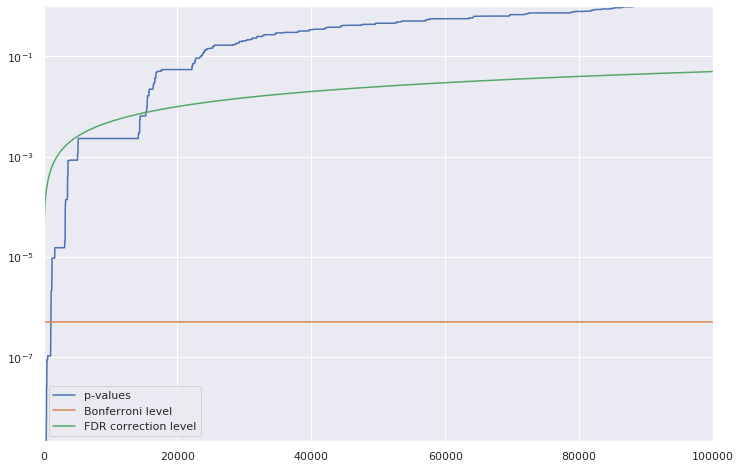

In [16]:
from sklearn.feature_selection import f_regression

_, pvals = f_regression(X=X, y=y)
alpha = 0.05

plt.figure(figsize=(12, 8))

plt.plot(np.arange(len(pvals)), np.sort(pvals), label='p-values')
plt.plot(np.arange(len(pvals)), len(pvals) * [alpha / len(pvals)], label='Bonferroni level')
plt.plot(np.arange(len(pvals)), np.arange(1, len(pvals) + 1) * alpha / len(pvals), label='FDR correction level')
plt.legend()
plt.yscale('log')
plt.xlim(0, 100000)
plt.ylim(np.exp(-20), np.exp(0))
plt.show()

In [17]:
class FTestCorrector:
    def __init__(self, alpha=0.1, method='bonferroni'):
        self.alpha = alpha
        self.mask = None
        self.method = method
        
    def fit(self, X, y):
        from sklearn.feature_selection import f_regression
        _, pvals = f_regression(X=X, y=y)
        if self.method == 'bonferroni':
            self.mask = pvals <= self.alpha / X.shape[1]
        elif self.method == 'fdr':
            self.mask, *_ = multitest.multipletests(pvals, alpha=self.alpha, method='fdr_bh')
        else:
            ValueError('No such method')
        return self
        
    def transform(self, X):
        return X[:, self.mask]

In [18]:
lr = LogisticRegression(solver='liblinear')

ftcorr = FTestCorrector(method='bonferroni', alpha=0.1)
pline = Pipeline([('ftest', ftcorr), ('lr', lr)])

In [19]:
cross_val_score(estimator=pline, X=X,
                y=y, cv=StratifiedKFold(n_splits=5, shuffle=True), scoring="roc_auc").mean()

0.8784243295019157

In [20]:
ftcorr = FTestCorrector(method='fdr', alpha=0.1)
pline = Pipeline([('ftest', ftcorr), ('lr', lr)])

In [21]:
cross_val_score(estimator=pline, X=X,
                y=y, cv=StratifiedKFold(n_splits=5, shuffle=True), scoring="roc_auc").mean()

0.9370324473180076

In [22]:
from xgboost import XGBClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import warnings
warnings.filterwarnings("ignore")

models = {
    'LogisticRegression': LogisticRegression(),
    'GaussianNB': GaussianNB(),
    'KNeighborsClassifier': KNeighborsClassifier(),
    'XGBClassifier': XGBClassifier()
}

In [23]:
# Будем классифицировать по отдельным людям и по 12 сессиям отдельно.
cv = 10
alpha = 0.01
methods = ['bonferroni', 'fdr']


scores = defaultdict(lambda: defaultdict(float))
for model in models:
    for method in methods:
        print("Processing %s %s" % (model, method))
        ftcorr = FTestCorrector(method=method, alpha=alpha)
        pline = Pipeline([('ftest', ftcorr), (model, models[model])])
        scores[model][method] = cross_val_score(estimator=pline, X=X,
                                                y=y, cv=StratifiedKFold(n_splits=cv, shuffle=True), scoring="roc_auc")

Processing LogisticRegression bonferroni
Processing LogisticRegression fdr
Processing GaussianNB bonferroni
Processing GaussianNB fdr
Processing KNeighborsClassifier bonferroni
Processing KNeighborsClassifier fdr
Processing XGBClassifier bonferroni
Processing XGBClassifier fdr


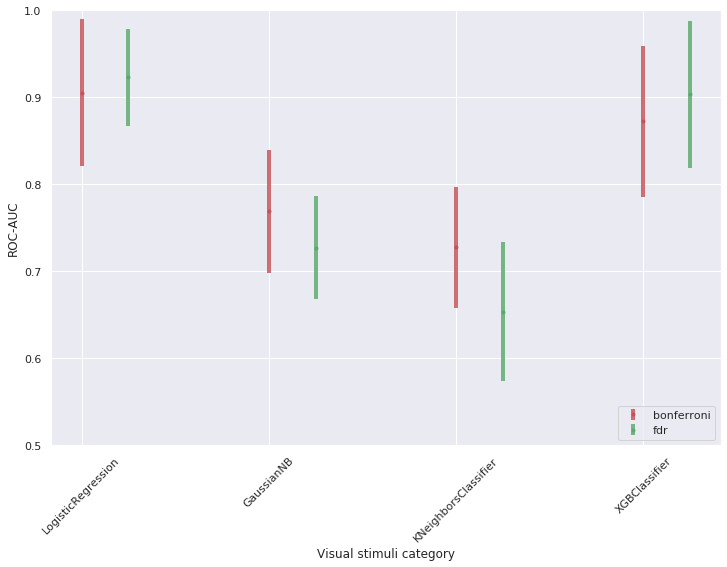

In [24]:
plt.figure(figsize=(12, 8))

tick_position = np.arange(len(models))
plt.xticks(tick_position, models.keys(), rotation=45)

for color, method in zip('rg', methods):
    score_means = [scores[model][method].mean() for model in models]
    score_stds = [scores[model][method].std() for model in models]
    plt.errorbar(tick_position, score_means, yerr=score_stds, fmt='.', lw=4, alpha=0.8, label=method, 
                 color=color)
    tick_position = tick_position + .25

plt.ylabel('ROC-AUC')
plt.xlabel('Visual stimuli category')
plt.ylim(0.5, 1.)
plt.legend(loc='lower right')
plt.show()

# 4. Апостериорные тесты (Tukey, Holm-Sidak tests и другие)

![](cylinders.jpeg)

Здесь мы будем смотреть на MPG(=Miles Per Gallon) и сравнивать их средние значения для разных количеств цилиндров с помощью разных тестов на множественные сравнения.

In [25]:
data = pd.read_csv('./auto_mpg.data',sep='\s+',names = ['MPG','Cylinders','Displacement','Horse power','Weight','Acceleration','Model Year','Origin','Car Name'])

In [26]:
cylinders = data.Cylinders.values
mpg = data.MPG.values

In [27]:
cylinders_unique = np.unique(cylinders)

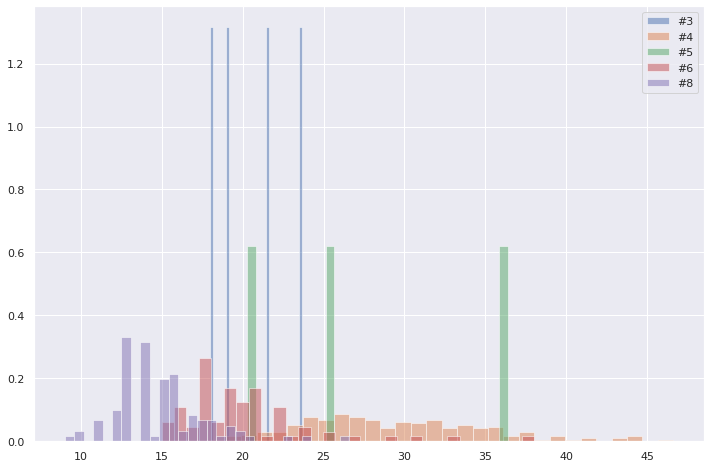

In [28]:
plt.figure(figsize=(12, 8))
for cylinder in cylinders_unique:
    plt.hist(mpg[cylinders==cylinder], bins=30, alpha=0.5, label='#{}'.format(cylinder), density=True)
plt.legend()
plt.show()

In [29]:
from statsmodels.sandbox.stats.multicomp import MultiComparison

In [30]:
from statsmodels.stats.multitest import multipletests

In [31]:
multicomp = MultiComparison(mpg, cylinders)

## Пакет `statsmodels`

Пакет `statsmodels` содержит прекрасные функции `MultiComparison` и `multipletests` в которых реализованы практически все возможные тесты.

![](types_corrections.png)

In [32]:
['bonferroni', 'sidak', 'holm-sidak', 'holm', 
 'simes-hochberg', 'hommel', 'fdr_bh', 'fdr_by', 
 'fdr_tsbh', 'fdr_tsbky']

['bonferroni',
 'sidak',
 'holm-sidak',
 'holm',
 'simes-hochberg',
 'hommel',
 'fdr_bh',
 'fdr_by',
 'fdr_tsbh',
 'fdr_tsbky']

Всё что нужно, это указать какой именно тест для множественных сравнений вы используете и функцию, которая генерирует p-values для пар групп.

К примеру, мы можем посмотреть на то как работает t-тест и критерий Манна-Уитни с Benjamini/Hochberg коррекцией для нашей задачи.

In [61]:
from scipy.stats import ttest_ind, mannwhitneyu, kstest

In [ ]:
kstest()

### Критерий Манна-Уитни c Bonferroni и Benjamini/Hochberg коррекцией

In [34]:
sumtab, *_ = multicomp.allpairtest(testfunc=mannwhitneyu, alpha=0.01, 
                                   method='bonferroni')

In [35]:
sumtab

group1,group2,stat,pval,pval_corr,reject
3,4,45.5,0.0012,0.0119,True
3,5,2.0,0.108,1.0,False
3,6,132.0,0.2378,1.0,False
3,8,27.0,0.0016,0.0158,True
4,5,246.0,0.2816,1.0,False
4,6,1206.5,0.0,0.0,True
4,8,165.0,0.0,0.0,True
5,6,36.5,0.019,0.1897,False
5,8,4.0,0.002,0.02,True
6,8,895.5,0.0,0.0,True


In [36]:
sumtab, *_ = multicomp.allpairtest(testfunc=mannwhitneyu, alpha=0.01, 
                                   method='fdr_bh')

In [37]:
sumtab

group1,group2,stat,pval,pval_corr,reject
3,4,45.5,0.0012,0.003,True
3,5,2.0,0.108,0.135,False
3,6,132.0,0.2378,0.2643,False
3,8,27.0,0.0016,0.0032,True
4,5,246.0,0.2816,0.2816,False
4,6,1206.5,0.0,0.0,True
4,8,165.0,0.0,0.0,True
5,6,36.5,0.019,0.0271,True
5,8,4.0,0.002,0.0033,True
6,8,895.5,0.0,0.0,True


### t-тест c Benjamini/Hochberg коррекцией

In [38]:
sumtab, *_ = multicomp.allpairtest(testfunc=ttest_ind, alpha=0.01, 
                                   method='fdr_bh')

In [39]:
sumtab

group1,group2,stat,pval,pval_corr,reject
3,4,-3.0483,0.0026,0.0037,True
3,5,-1.6023,0.17,0.2125,False
3,6,0.2924,0.7707,0.7707,False
3,8,3.8754,0.0002,0.0004,True
4,5,0.5752,0.5658,0.6287,False
4,6,13.7186,0.0,0.0,True
4,8,23.9936,0.0,0.0,True
5,6,3.1655,0.0021,0.0036,True
5,8,6.9851,0.0,0.0,True
6,8,10.3295,0.0,0.0,True


### Критерий Манна-Уитни c Holm-Sidak коррекцией


Очень похож на Бонферрони, но граничные $\alpha$ для $m$ гипотез считаются следующим образом:

$$ \alpha_{(1)} = 1 - (1 - \alpha)^{1/m},  \alpha_{(2)} = 1 - (1 - \alpha)^{1/(m-1)}, \dots, \alpha_{(m)} = 1 - (1 - \alpha)^{1}$$

Этот тест более мощный чем Бонферрони.

In [40]:
sumtab, *_ = multicomp.allpairtest(testfunc=ttest_ind, alpha=0.01, 
                                   method='holm-sidak')

In [41]:
sumtab

group1,group2,stat,pval,pval_corr,reject
3,4,-3.0483,0.0026,0.0107,True
3,5,-1.6023,0.17,0.4282,False
3,6,0.2924,0.7707,0.8115,False
3,8,3.8754,0.0002,0.0011,True
4,5,0.5752,0.5658,0.8115,False
4,6,13.7186,0.0,0.0,True
4,8,23.9936,0.0,0.0,True
5,6,3.1655,0.0021,0.0107,True
5,8,6.9851,0.0,0.0,True
6,8,10.3295,0.0,0.0,True


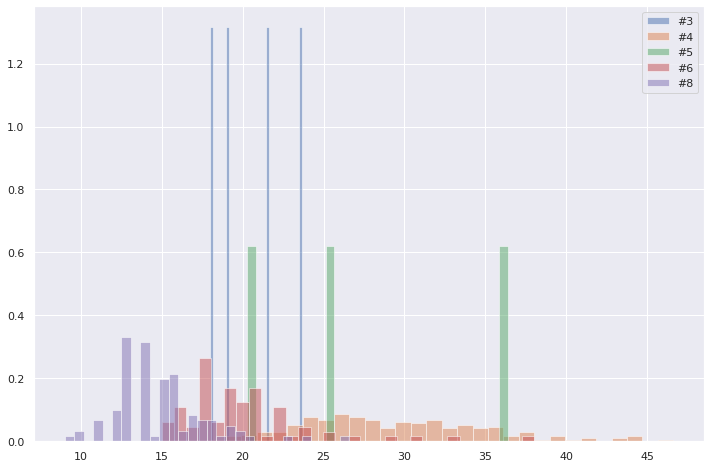

In [42]:
plt.figure(figsize=(12, 8))
for cylinder in cylinders_unique:
    plt.hist(mpg[cylinders==cylinder], bins=30, alpha=0.5, label='#{}'.format(cylinder), density=True)
plt.legend()
plt.show()